In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gudhi
from tqdm import tqdm
from numba import jit

In [2]:
@jit(forceobj=True)
def number_of_b0_b1(p):
    rips = gudhi.RipsComplex(points = p, max_edge_length = 2)
    s_tree = rips.create_simplex_tree(max_dimension = 2)
    diag = s_tree.persistence()
    b0, b1 = 0, 0
    for dg in diag:
        if(dg[1][1] >= 1.42 or dg[1][1] == np.inf):
            if(dg[0] == 0):
                b0 += 1
            if(dg[0] == 1):
                b1 += 1
    return b0, b1

In [3]:
@jit(forceobj=True)
def image_to_point(X):
    points = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(X[i, j] == 0):
                a = np.array([i, j])
                points.append(a)
    points = np.array(points)
    return points

In [4]:
def local_merging_number(X, patches_x, patches_y, dir):
    x_b0, x_b1 = number_of_b0_b1(image_to_point(X))

    px_s = (int)(X.shape[0] / patches_x) 
    py_s = (int)(X.shape[1] / patches_y)
    while((X.shape[0] - patches_x * px_s) >= px_s):
      px_s += 1
    while((X.shape[1] - patches_y * py_s) >= py_s):
      py_s += 1
    print(f"{X.shape}, px_s = {px_s}, py_s = {py_s}")
    
    X1 = np.zeros([X.shape[0], X.shape[1], patches_x*patches_y]) + 255
    X2 = np.zeros([X.shape[0], X.shape[1], patches_x*patches_y]) + 255
    X1_U_X2 = np.zeros([X.shape[0], X.shape[1], patches_x*patches_y])
    Y = np.zeros([X.shape[0], X.shape[1]]) + 255

    offset = 0
    
    lg = np.zeros([(patches_x), (patches_y)])
    olg = np.zeros([(patches_x), (patches_y)])

    for i in tqdm(range(patches_x)):
      for j in range(patches_y):
        X1[ i*px_s + 1 : (i+1)*px_s, j*py_s + 1 : (j+1)*py_s, offset ] = np.array(X[i*px_s + 1 : (i+1)*px_s, j*py_s + 1 : (j+1)*py_s])
        x1_b0, x1_b1 = number_of_b0_b1(image_to_point(X1[i*px_s + 1 : (i+1)*px_s, j*py_s + 1 : (j+1)*py_s, offset]))

        X2[:, :, offset] = X
        X2[ i*px_s : (i+1)*px_s + 1, j*py_s + 1: (j+1)*py_s , offset] = 255
        x2_b0, x2_b1 = number_of_b0_b1(image_to_point(X2[:, :, offset]))

        # X1_U_X2[:, :] = X
        # X1_U_X2[i*px_s : (i+1)*px_s + 1, j*py_s : (j+1)*py_s + 1] = 255
        # X1_U_X2[i*px_s + 1 : (i+1)*px_s, j*py_s + 1 : (j+1)*py_s] = X1[i*px_s + 1 : (i+1)*px_s, j*py_s + 1 : (j+1)*py_s]
        # u_b0, u_b1 = number_of_b0_b1(image_to_point(X1_U_X2[:, :]))

        if(x_b1 > (x1_b1 + x2_b1)):
          olg[i, j] += (x_b1 - (x1_b1 + x2_b1))
          Y[i*px_s : (i+1)*px_s + 1, j*py_s: (j+1)*py_s + 1] = np.array(X[i*px_s : (i+1)*px_s + 1, j*py_s: (j+1)*py_s + 1])
          # cv2.imwrite(f"./image_Y_{offset}.png", Y)

        # cv2.imwrite(f"./image_X1_{offset}.png", X1[:,:, offset])
        # cv2.imwrite(f"./image_X2_{offset}.png", X2[:,:, offset])
        # cv2.imwrite(f"./image_X1UX2_{offset}.png", X1_U_X2[:,:, offset])

        offset += 1
    return lg,olg, Y

In [5]:
img = cv2.imread('./images/qr-code-7.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,X = cv2.threshold(img,70,255,cv2.THRESH_BINARY)

In [6]:
X.shape

(928, 928)

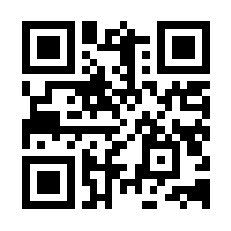

In [7]:
orig_map = plt.cm.get_cmap('Greys')
rev_map = orig_map.reversed()

fig1, ax1 = plt.subplots()
ax1.axis('off')
ax1.imshow(X, cmap = rev_map);

In [8]:
X_ = cv2.resize(X, [(int)(X.shape[0]/5), (int)(X.shape[1]/5)])

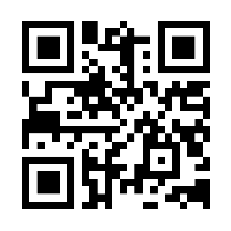

In [9]:
fig2, ax2 = plt.subplots()
ax2.axis('off')
ax2.imshow(X_, cmap = rev_map);

In [13]:
lg_num, olg_num, heat_map = local_merging_number(X_, 8, 8, "croped")

(185, 185), px_s = 23, py_s = 23


100%|██████████| 8/8 [00:56<00:00,  7.03s/it]


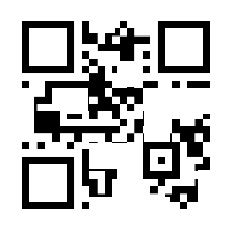

In [14]:
fig3, ax3 = plt.subplots()
ax3.axis('off')
ax3.imshow(heat_map, cmap = rev_map);